# For Jax Cosmo

In [1]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sacc
import jax
# import optax
from jax import grad, jit, vmap, jacfwd, hessian
from jax import random
import jax_cosmo as jc
import pyccl as ccl
from jax.config import config
config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15
save_plots = False
key = random.PRNGKey(0)

# Emulator or No Emulator

In [2]:
import jax_cosmo.power as jcp 
jcp.USE_EMU = False

# SACC File

In [3]:
saccfile = sacc.Sacc.load_fits('data/cls_DESY1.fits')

In [4]:
tracers_names = list(saccfile.tracers.keys())
nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])

# Redshift Distribution (Galaxy Clustering)

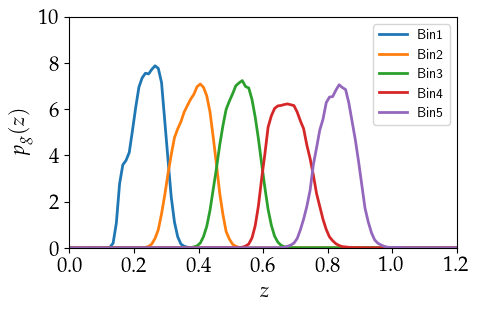

In [79]:
plt.figure(figsize=(5,3))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p_{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
# plt.savefig('plots/carlos_nz_gc.pdf', bbox_inches = 'tight')
if save_plots:
    plt.savefig('../plots/carlos_nz_gc.pdf', bbox_inches = 'tight')
plt.show()

# Using Jax Cosmo

If we want to use JAX cosmo to get the redshift distributions. 

In [6]:
jax_nz_gc = list()
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    zmax = 2.9999 # max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float64'), distribution.nz.astype('float64'), zmax = zmax)
    jax_nz_gc.append(jaxred)

In [7]:
redshifts = distribution.z.astype('float64')

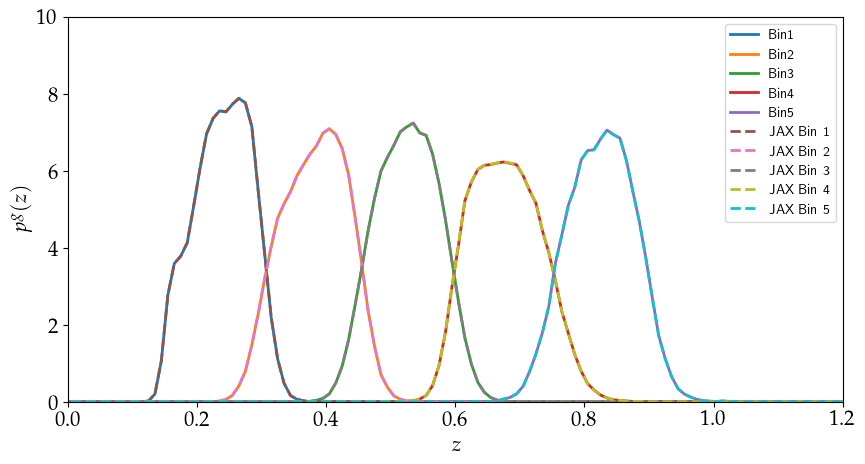

In [8]:
plt.figure(figsize=(10,5))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_gc):
    plt.plot(redshifts, jax_nz_gc[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_gc_jax.pdf', bbox_inches = 'tight')
plt.show()

# Redshift Distribution (Weak Lensing)

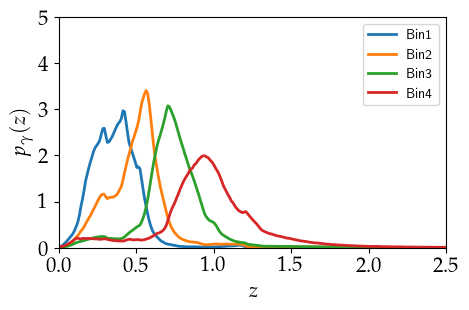

In [78]:
plt.figure(figsize=(5,3))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p_{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
# plt.savefig('plots/carlos_nz_wl.pdf', bbox_inches = 'tight')
if save_plots:
    plt.savefig('plots/carlos_nz_wl.pdf', bbox_inches = 'tight')
plt.show()

# Using JAX Cosmo

In [10]:
jax_nz_wl = list()
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    zmax = 2.9999 # max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float64'),distribution.nz.astype('float64'), zmax = zmax)
    jax_nz_wl.append(jaxred)

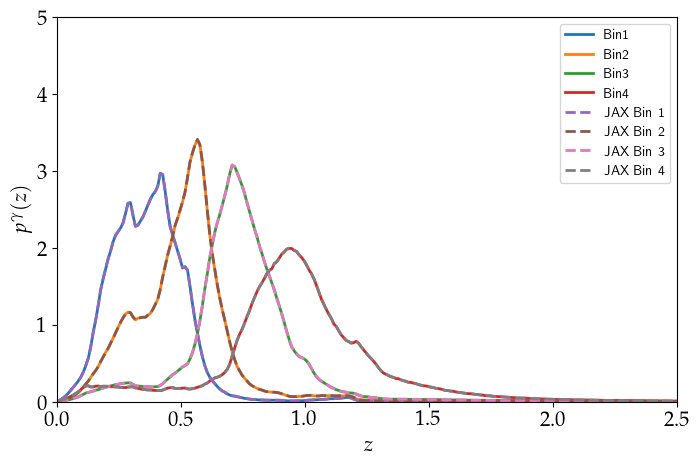

In [11]:
plt.figure(figsize=(8,5))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_wl):
    plt.plot(redshifts, jax_nz_wl[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl_jax.pdf', bbox_inches = 'tight')
plt.show()

# Scale Cuts

In [12]:
# Now impose scale cuts for galaxy clustering and galaxy-galaxy lensing
# Maximum multipole for the 5 different galaxy redshift bins
# lmaxs = [145, 225, 298, 371, 435]

In [13]:
def calculate_lmax_gc(sfile, kmax):
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    vanillacosmo = jc.Planck15() # ccl.CosmologyVanillaLCDM()
    lmaxs = list()
    
    for i in range(nbin_gc):
        tracer = sfile.tracers[f'DESgc__{i}']
        zmid = jnp.average(jnp.asarray(tracer.z), weights=jnp.asarray(tracer.nz))
        chi = jc.background.radial_comoving_distance(vanillacosmo, 1./(1. + zmid))
        minmax = jnp.concatenate([10.*jnp.ones(1), kmax * chi - 0.5], dtype = int)
        lmax = jnp.max(minmax)
        lmaxs.append(lmax)
    return lmaxs

In [14]:
def scale_cuts(sfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000):
    # First we remove all B-modes
    sfile.remove_selection(data_type='cl_bb')
    sfile.remove_selection(data_type='cl_be')
    sfile.remove_selection(data_type='cl_eb')
    sfile.remove_selection(data_type='cl_0b')

    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    lmaxs_gc = calculate_lmax_gc(sfile, kmax)
    
    for i, lmax in enumerate(lmaxs_gc):
        print(f'Maximum ell is {lmax}')
        tname_1 = f'DESgc__{i}'
        
        # Remove from galaxy clustering
        sfile.remove_selection(data_type='cl_00', tracers=(tname_1, tname_1), ell__gt=lmax)
        
        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_0e', tracers=(tname_1, tname_2), ell__gt=lmax)
    
    # apply scale cut for weak lensing 
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tname_1 = f'DESwl__{i}'
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__gt= lmax_wl)
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__lt= lmin_wl)
            
    return sfile, lmaxs_gc

In [15]:
saccfile_cut, lmaxs_gc = scale_cuts(saccfile, kmax = 0.15, lmin_wl = 30, lmax_wl = 2000)

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


# Bandwindow

In [16]:
def interpolate(ellvalues, clvalues, newells):
    ellvalues_log = jnp.log(ellvalues)
    clvalues_log = jnp.log(clvalues)
    newells_log = jnp.log(newells)
    interpolation = jnp.interp(newells_log, ellvalues_log, clvalues_log)
    interp_final = jnp.exp(interpolation)
    return interp_final

def get_data_type(tracer_combination):
    if 'gc' in tracer_combination[0] and 'gc' in tracer_combination[1]:
        dtype = 'cl_00'
    elif 'gc' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_0e'
    elif 'wl' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_ee'
    return dtype

def get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax = 3000):
    
    dtype = get_data_type((tracer_name_1, tracer_name_2))    
    idx = sfile.indices(data_type=dtype, tracers=(tracer_name_1, tracer_name_2))
    window = sfile.get_bandpower_windows(idx)
    fine_ells = window.values
    indices = (fine_ells >= 2) & (fine_ells <= ellmax)
    fine_ells = jnp.asarray(fine_ells[indices], dtype = jnp.float32)
    bandwindow = jnp.asarray(window.weight[indices])
    return fine_ells, bandwindow

def extract_bandwindow(sfile, ellmax = 3000):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    record = dict()
    
    # galaxy-galaxy 
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        key = f'{tracer_name},{tracer_name}'
        ells, bandwindow = get_ells_bandwindow(sfile, tracer_name, tracer_name, ellmax)
        record[key] = {'ells': ells, 'bandwindow': bandwindow}

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
            record[key] = {'ells': ells, 'bandwindow': bandwindow}
            
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
            record[key] = {'ells': ells, 'bandwindow': bandwindow}

    return record

In [17]:
record_band = extract_bandwindow(saccfile_cut, ellmax = 3000)

# Data - Galaxy Clustering 

In [18]:
def plot_data_gc(sfile, lmaxs_gc, xlabel, ylabel, ell_grid = None, theory = None, nx = 5, ylims = (1E-6, 5E-4), fontsize = 12, fname = 'data_galaxy_clustering'):

    f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))

    for counter in range(nx):

        tracername = f'DESgc__{counter}'
        ell, c_ell, covariance, indices = sfile.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
        covariance = np.asarray(covariance)
        sigma = np.sqrt(np.diag(covariance))
        labz = f'$p_{counter+1}(z)$'

        ax[counter].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        if theory is not None:
            ax[counter].plot(ell_grid, theory[counter], lw = 1, c = 'k', linestyle = '--')
        ax[counter].set_xlabel(xlabel, fontsize=fontsize)
        ax[counter].set_xlim(min(ell)-5, max(ell)+25)
        ax[counter].set_ylim(ylims[0], ylims[1])
        ax[counter].set_xscale("log")
        ax[counter].set_yscale("log")
        ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[counter].tick_params(axis='both', which='both', length=0)
        ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
        if counter==0 :
            ax[counter].set_ylabel(ylabel, fontsize=fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fname and save_plots:
        plt.savefig(f'../plots/{fname}.pdf', bbox_inches='tight')
    plt.show()

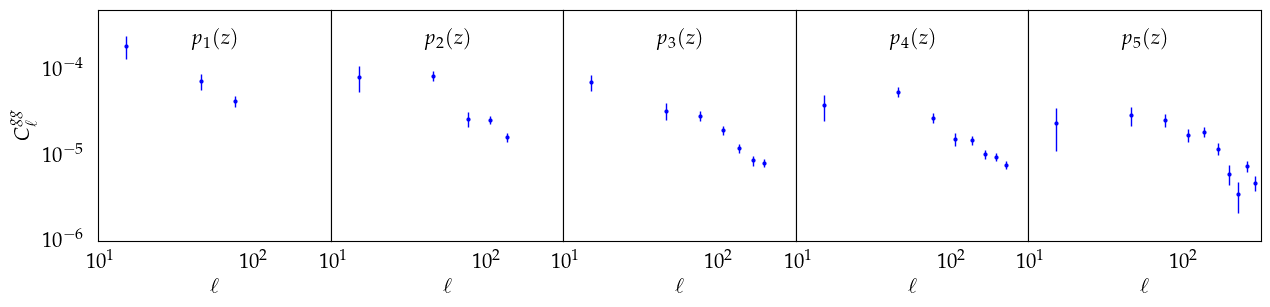

In [19]:
yLabel = r'$C_{\ell}^{gg}$'
xLabel = r'$\ell$'
plot_data_gc(sfile=saccfile_cut, lmaxs_gc=lmaxs_gc, xlabel=xLabel, ylabel=yLabel, fontsize=fontSize, fname = 'carlos_data_gc')

In [20]:
# tracername = f'DESgc__0'
# ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
# ell

# Using JAX 
To get the $C_{\ell}^{gg}$. Some functions are borrowed from the JAX cosmo paper. 

In [21]:
def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    bias_1, bias_2, bias_3, bias_4, bias_5 = bias
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = deltaz_gc
    return jnp.array([
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b, cosmo.h, cosmo.n_s,
        mparam_1, mparam_2, mparam_3, mparam_4,
        dz1, dz2, dz3, dz4,
        a_ia_param, eta_param,
        bias_1, bias_2, bias_3, bias_4, bias_5, 
        dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5
    ])
    
def unpack_params_vec(params):
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=-1.0, Omega_k=0., wa=0.)
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    bias = params[15:20]
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5 = params[20:25]
    return cosmo, [mparam_1, mparam_2, mparam_3, mparam_4], [dz1,dz2,dz3,dz4], [a_ia_param, eta_param], bias, [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5]

def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j+nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index

In [51]:
# cosmo =  jc.Cosmology(sigma8=0.75, Omega_c=0.2589, Omega_b=0.0486, h=0.6774, n_s=0.9667, 
#                       w0=-1., Omega_k=0., wa=0.)

# params = get_params_vec(cosmo, 
#                             [0., 0., 0., 0.],
#                             [0., 0., 0., 0.],
#                             [0.5, 0.],
#                             [1.2, 1.4, 1.6, 1.8, 2.0],
#                             [0., 0., 0., 0., 0.])

# cosmo = jc.Cosmology(sigma8=0.8521117261609208, Omega_c = 0.2393475153665476, Omega_b=0.05395308811150879, 
#                      h = 0.6529206102826096, n_s=0.9330022578443745, w0=-1., Omega_k=0., wa=0.)

cosmo = jc.Cosmology(sigma8=0.841, 
                     Omega_c = 0.229, 
                     Omega_b=0.043, 
                     h = 0.717, 
                     n_s=0.960, 
                     w0=-1., Omega_k=0., wa=0.)


# params = get_params_vec(cosmo, 
#                        [0.07377626, 0.18572161, -0.07526319, -0.10828671], 
#                        [-0.00846738, -0.10025093, -0.00177734, -0.00968797], 
#                        [0.35898907, -0.01135033], 
#                        [1.33889417, 1.57640662, 1.59644491, 1.90517272, 1.93960129], 
#                        [0.02246754, -0.00146808, 0.02051478, 0.00968391, -0.01231999])

params = get_params_vec(cosmo, 
                       [0.012, 0.011, 0.019, 0.009], 
                       [-0.002, -0.029, 0.007, -0.020], 
                       [0.363, 0.034], 
                       [1.381, 1.691, 1.650, 2.041, 2.076], 
                       [0.001, 0.001, 0.002, 0.002, 0.000])

cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(params) 

In [52]:
nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias] 
b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

probes_gc = [jc.probes.NumberCounts(jax_nz_gc, gc_biases)]
probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
probes_gc_wl = probes_gc + probes_wl

In [53]:
tracer_combinations = saccfile_cut.get_tracer_combinations()
tracers = list(saccfile_cut.tracers.keys())

In [54]:
%%capture
ell_grid_gc = jnp.geomspace(2, 300, 50)
idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
cls_gc = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc, index_pairs = idx_pairs_gc)

In [55]:
%%capture
idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
cls_gc_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc_wl, index_pairs = idx_pairs_gc_wl)

In [56]:
%%capture
ell_grid_wl = jnp.geomspace(2, 2000, 50)
idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
cls_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_wl, probes_wl, index_pairs = idx_pairs_wl)

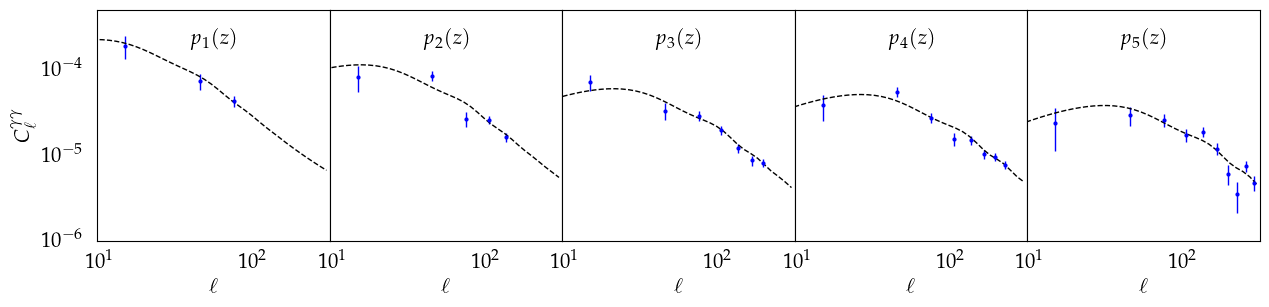

In [57]:
plot_data_gc(saccfile_cut, lmaxs_gc, xLabel, yLabel, ell_grid = ell_grid_gc, theory = cls_gc, fontsize=fontSize, fname = 'carlos_data_gc')

# Data - Galaxy Clustering and Weak Lensing

Number of ell: 3
Number of ell: 3
Number of ell: 3
Number of ell: 3
Number of ell: 5
Number of ell: 5
Number of ell: 5
Number of ell: 5
Number of ell: 7
Number of ell: 7
Number of ell: 7
Number of ell: 7
Number of ell: 8
Number of ell: 8
Number of ell: 8
Number of ell: 8
Number of ell: 10
Number of ell: 10
Number of ell: 10
Number of ell: 10


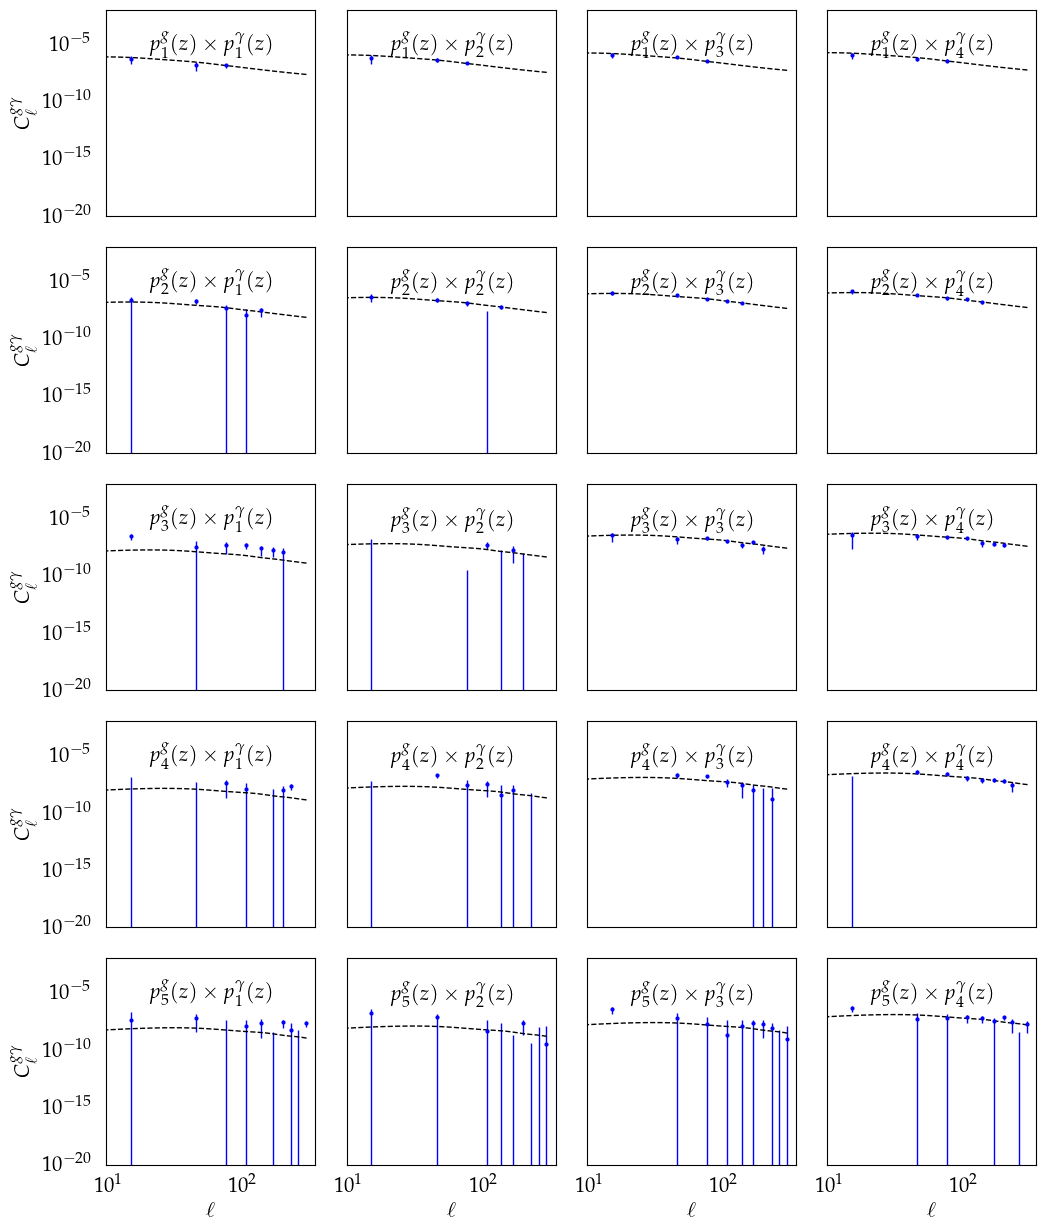

In [58]:
yLabel = r'$C_{\ell}^{g\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-20, 1E-2]
fontsize = fontSize

f, ax = plt.subplots(nbin_gc, nbin_wl, sharex=True, sharey = True, figsize = (12, 15))
counter = 0
for i in range(nbin_gc):
    for j in range(nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{g}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_gc = f'DESgc__{i}'
        tracername_wl = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_0e', tracername_gc, tracername_wl, return_cov=True, return_ind=True)
        covariance = np.asarray(covariance)
        sigma = np.sqrt(np.diag(covariance))
        print(f'Number of ell: {len(ell)}')

        ax[i,j].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[i,j].plot(ell_grid_gc, cls_gc_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[i,j].set_xlim(min(ell)-5, max(ell)+50)
        ax[i,j].set_ylim(ylims[0], ylims[1])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if j==0 :
            ax[i,j].set_ylabel(yLabel, fontsize=fontsize)
        if i==nbin_gc-1:
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            
        counter += 1

f.subplots_adjust(wspace=0.15)
f.subplots_adjust(hspace=0.15)
if save_plots:
    plt.savefig(f'../plots/carlos_data_gc_shear.pdf', bbox_inches='tight')
plt.show()

# Data - Weak Lensing

Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00
Number of ells is 24, minimum ell is 44.50 and maximum ell is 1949.00


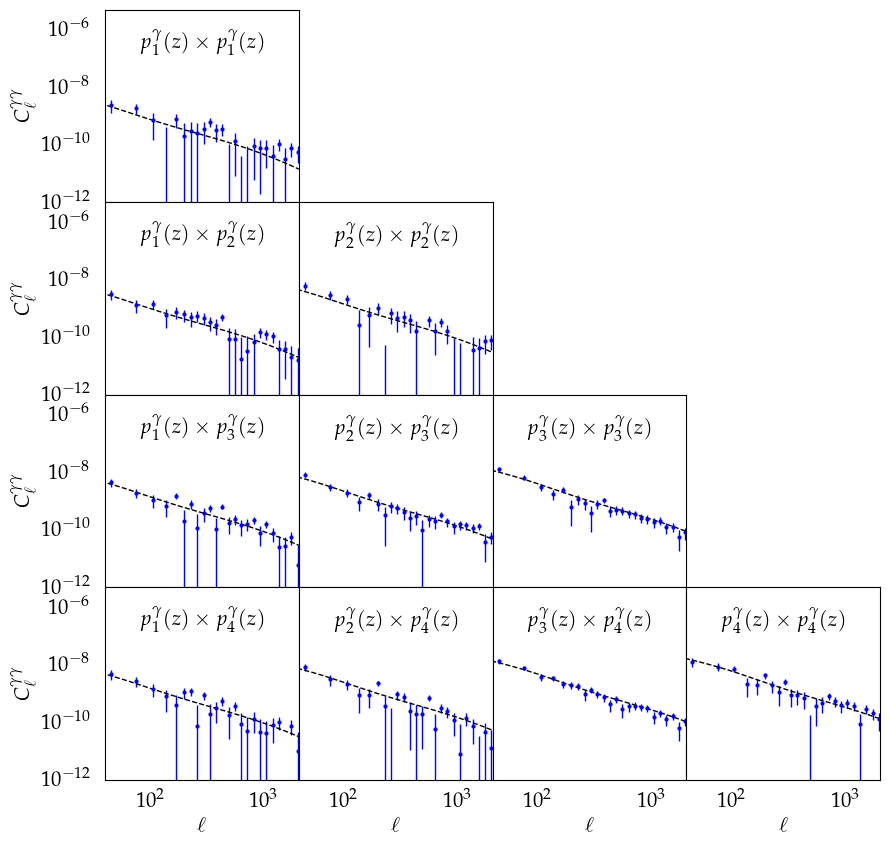

In [59]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 5E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        print(f'Number of ells is {len(ell)}, minimum ell is {min(ell):.2f} and maximum ell is {max(ell):.2f}')
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
if save_plots:
    plt.savefig(f'../plots/carlos_data_shear_shear.pdf', bbox_inches='tight')
plt.show()

# Extract the Data Vector and the Covariance

In [60]:
def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    indices = []
    idxpositions = []
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        _, _, ind = saccfile.get_ell_cl('cl_00', tracer_name, tracer_name, return_cov=False, return_ind=True)
        indices += list(ind)
    idxpositions.append(len(indices))

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_0e', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
            
    idxpositions.append(len(indices))
        
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_ee', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
    idxpositions.append(len(indices))

    indices = np.array(indices)
    idxpositions = np.hstack([np.zeros(1), np.array(idxpositions)])
    
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return data, covariance, idxpositions

In [61]:
data, datacov, idxpositions = extract_data_covariance(saccfile_cut)

In [62]:
scaledcov = datacov/np.sqrt(np.outer(np.diag(datacov), np.diag(datacov)))
delta = np.diff(idxpositions)
mid = np.array(idxpositions[:-1] + delta/2, dtype = int)

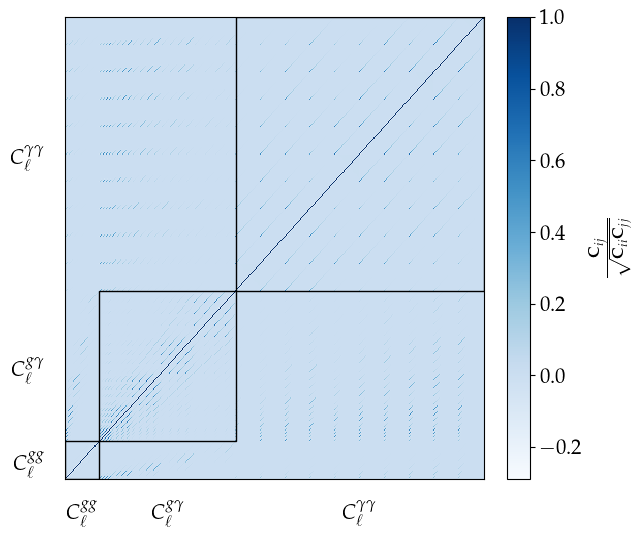

In [63]:
column_labels = [r'$C_{\ell}^{gg}$', r'$C_{\ell}^{g\gamma}$', r'$C_{\ell}^{\gamma\gamma}$']
colormap = plt.cm.Blues

fig, ax = plt.subplots(figsize = (6, 6))

heatmap = ax.pcolor(scaledcov, cmap=colormap, rasterized=True)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=fontSize)
cbar.ax.tick_params(labelsize=fontSize) 

rect1 = patches.Rectangle((idxpositions[0], idxpositions[0]), delta[0], delta[0], linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((idxpositions[1], idxpositions[1]), delta[1], delta[1], linewidth=1, edgecolor='k', facecolor='none')
rect3 = patches.Rectangle((idxpositions[2], idxpositions[2]), delta[2], delta[2], linewidth=1, edgecolor='k', facecolor='none')
# rect4 = patches.Rectangle((800, 800), 100, 100, linewidth=1, edgecolor='k', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
# ax.add_patch(rect4)

ax.set_xticks(mid, minor=False)
ax.set_yticks(mid, minor=False)

ax.set_xticklabels(column_labels, minor=False, fontsize=fontSize)
ax.set_yticklabels(column_labels, minor=False, fontsize=fontSize)
ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)

if save_plots:
    plt.savefig(f'../plots/carlos_covariance.pdf', bbox_inches='tight')

plt.show()

# Band Window Matrix

$$
C_{\ell, ij}^{\textrm{binned}} = W^{\textrm{T}}_{\ell, ij}C_{\ell,ij}
$$

In [64]:
idx = saccfile.indices(data_type='cl_00', tracers=('DESgc__0', 'DESgc__0'))
window = saccfile.get_bandpower_windows(idx)
ells = window.values
bandwindow = window.weight

In [65]:
get_data_type(tracer_combinations[0])

'cl_00'

In [66]:
get_data_type(tracer_combinations[5])

'cl_0e'

In [67]:
get_data_type(tracer_combinations[-1])

'cl_ee'

# Bandpowers for Galaxy Clustering

In [68]:
def gc_bandpower_calculation(cosmology, galaxybias, nz_gc, deltaz_gc, record_band, 
                             tracer_combinations, ellmax=3000, nell = 30):
    
    # calculate the coarse power spectra for galaxy clustering
    nbin_gc = len(nz_gc)
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in galaxybias]     
    nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(nz_gc, deltaz_gc)]

    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    ells_coarse = jnp.geomspace(2, ellmax, nell, dtype=jnp.float32)
    idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
    ps_gc = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_gc, index_pairs = idx_pairs_gc)
    
    # list to record the band powers
    recordbandpowers = dict()
    
    for i in range(nbin_gc):
        tracername = f'DESgc__{i}'
        key = f'{tracername},{tracername}'
        
        # build the interpolated cls 
        cls_gc_interp = interpolate(ells_coarse, ps_gc[i], record_band[key]['ells'])
        
        # calculate binned cls 
        recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp

    return recordbandpowers          

In [69]:
%%capture
bandpowers_gc = gc_bandpower_calculation(cosmo, bias, jax_nz_gc, deltaz_gc, record_band, tracer_combinations)

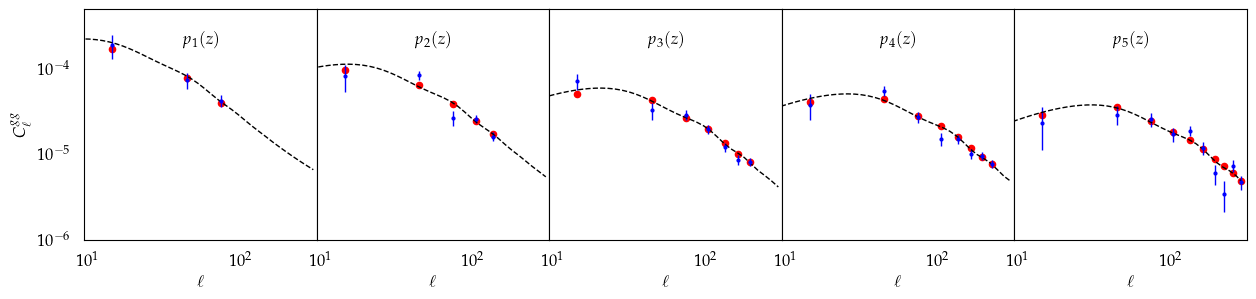

In [70]:
nx = 5 
ylims = (1E-6, 5E-4)
fontsize = 12
ylabel = r'$C_{\ell}^{gg}$'
xlabel = r'$\ell$'

f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))

for counter in range(nx):

    tracername = f'DESgc__{counter}'
    ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
    sigma = np.sqrt(np.diag(covariance))
    labz = f'$p_{counter+1}(z)$'
    key = f'{tracername},{tracername}'

    ax[counter].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
    ax[counter].scatter(ell, bandpowers_gc[key], s = 20, c = 'r')
    ax[counter].plot(ell_grid_gc, cls_gc[counter], lw = 1, c = 'k', linestyle = '--')
    ax[counter].set_xlabel(xlabel, fontsize=fontsize)
    ax[counter].set_xlim(min(ell)-5, max(ell)+25)
    ax[counter].set_ylim(ylims[0], ylims[1])
    ax[counter].set_xscale("log")
    ax[counter].set_yscale("log")
    ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
    ax[counter].tick_params(axis='both', which='both', length=0)
    ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
    if counter==0 :
        ax[counter].set_ylabel(ylabel, fontsize=fontsize)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Bandpowers for Weak Lensing

In [71]:
def wl_bandpower_calculation(cosmology, deltaz_wl, nz_wl, a_ia_param, eta_param, multiplicative, record_band, tracer_combinations, ellmax=3000, nell = 30):
    
    nbin_wl = len(nz_wl)
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(nz_wl, deltaz_wl)]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, ellmax, nell, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_wl, index_pairs = idx_pairs_wl)

    # list to record the band powers
    recordbandpowers = dict()
    
    counter = 0
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            
            # tracer names and data types
            tracername_wl_i = f'DESwl__{i}'
            tracername_wl_j = f'DESwl__{j}'
            key = f'{tracername_wl_i},{tracername_wl_j}'
            
            # build the interpolated cls 
            cls_gc_interp = interpolate(ells_coarse, ps_wl[counter], record_band[key]['ells'])

            # calculate binned cls 
            recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp
            
            # update counter
            counter += 1
 
    return recordbandpowers  

In [72]:
bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz_wl, jax_nz_wl, a_ia_param,
                                         eta_param, multiplicative, record_band, tracer_combinations)

Not using the emulator


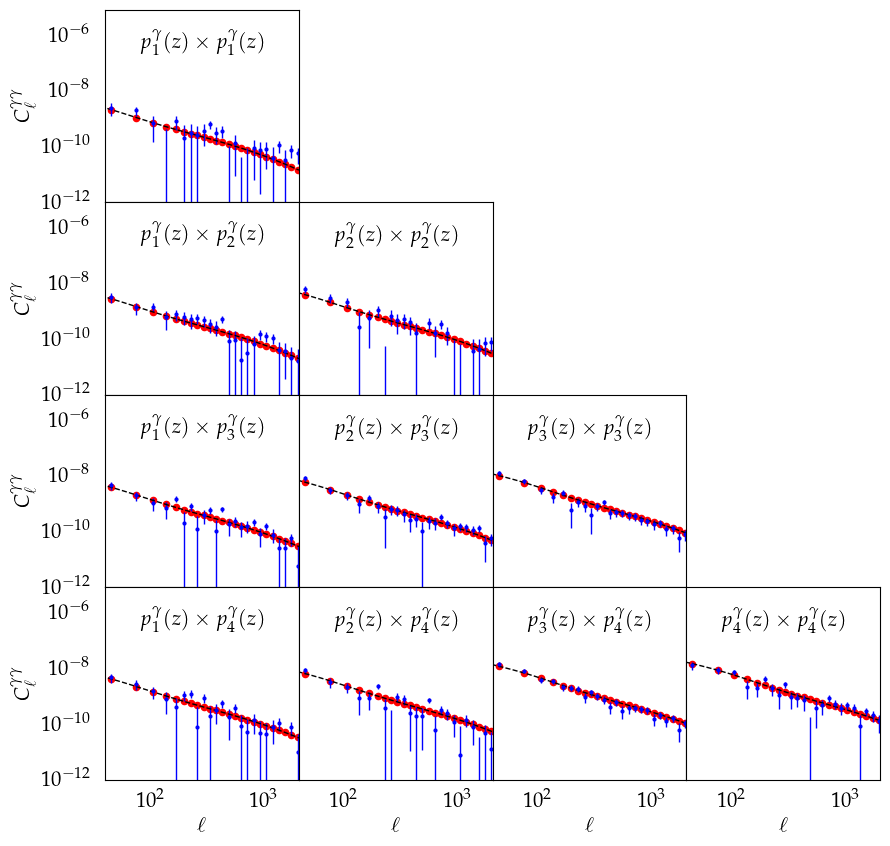

In [77]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 8E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        key = f'{tracername_wl_i},{tracername_wl_j}'
        
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].scatter(ell, bandpowers_wl[key], s = 20, c = 'r')
        ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1
f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
# plt.savefig('plots/cosmic_shear_fit.pdf', bbox_inches='tight')
plt.show()

# Bandpowers for Galaxy Clustering and Shear

In [48]:
def gc_wl_bandpower_calculation(cosmology, deltaz_wl, nz_wl, nz_gc, deltaz_gc, a_ia_param, eta_param, 
                                galaxybias, multiplicative, record_band, tracer_combinations, ellmax=3000, nell = 30):

    nbin_gc = len(nz_gc)
    nbin_wl = len(nz_wl)
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)]
    nz_gc_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)]
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in galaxybias] 
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    probes_gc_wl = probes_gc + probes_wl
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, ellmax, nell).astype(int).astype(float)
    idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
    ps_gc_wl = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_gc_wl, index_pairs = idx_pairs_gc_wl)

    # list to record the band powers
    recordbandpowers = dict()

    
    counter = 0
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            
            # tracer names and data types
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            
            # build the interpolated cls 
            cls_gc_interp = interpolate(ells_coarse, ps_gc_wl[counter], record_band[key]['ells'])

            # calculate binned cls 
            recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp
             
            # update counter
            counter += 1
    return recordbandpowers  

In [49]:
bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz_wl, jax_nz_wl, jax_nz_gc, deltaz_gc, a_ia_param, eta_param, 
                                bias, multiplicative, record_band, tracer_combinations)

Not using the emulator


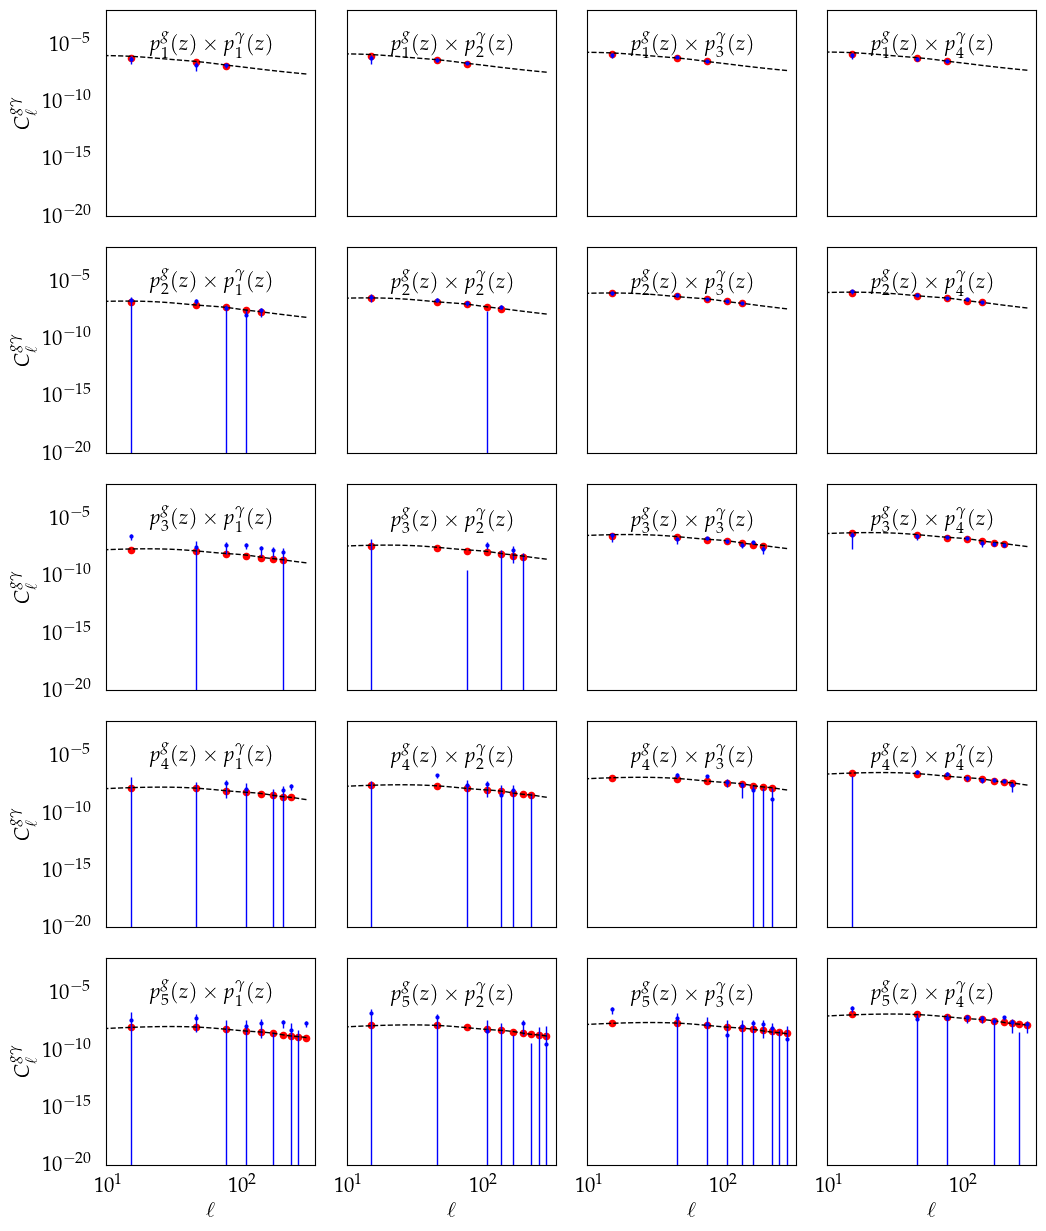

In [50]:
yLabel = r'$C_{\ell}^{g\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-20, 1E-2]
fontsize = fontSize

f, ax = plt.subplots(nbin_gc, nbin_wl, sharex=True, sharey = True, figsize = (12, 15))
counter = 0
for i in range(nbin_gc):
    for j in range(nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{g}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_gc = f'DESgc__{i}'
        tracername_wl = f'DESwl__{j}'
        key = f'{tracername_gc},{tracername_wl}'
        
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_0e', tracername_gc, tracername_wl, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[i,j].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[i,j].scatter(ell, bandpowers_gc_wl[key], s = 20, c = 'r')
        ax[i,j].plot(ell_grid_gc, cls_gc_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[i,j].set_xlim(min(ell)-5, max(ell)+50)
        ax[i,j].set_ylim(ylims[0], ylims[1])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if j==0 :
            ax[i,j].set_ylabel(yLabel, fontsize=fontsize)
        if i==nbin_gc-1:
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            
        counter += 1

f.subplots_adjust(wspace=0.15)
f.subplots_adjust(hspace=0.15)
plt.show()

# Get the Full Theory Vector

In [51]:
def extract_theory(gc_bandpowers, gc_wl_bandpowers, wl_bandpowers, tracers):
    ntracers = len(tracers)
    nbin_gc = sum(['DESgc__' in tracers[i] for i in range(ntracers)])
    nbin_wl = sum(['DESwl__' in tracers[i] for i in range(ntracers)])
    
    theory = list()
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        key = f'{tracer_name},{tracer_name}'
        theory.append(gc_bandpowers[key])

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            theory.append(gc_wl_bandpowers[key])

    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            theory.append(wl_bandpowers[key])
    return jnp.concatenate(theory)

# Likelihood Computation

In [52]:
DATA = jnp.asarray(data)
INVCOV = jnp.linalg.inv(jnp.asarray(datacov))
DATACOV = jnp.asarray(datacov)
PRECISION = jnp.linalg.inv(DATACOV)
NDATA = len(DATA) 

NZ_WL = jax_nz_wl
NZ_GC = jax_nz_gc
BANDWINDOW = record_band
TRACERS_COMB = tracer_combinations
TRACERS = tracers
ELLMAX = 3000
NELL = 30

## Negative log-likelihood

In this case, calculate the theory first, followed by the log-likelihood calculation.

NOTE: it seems that the first run takes some time (maybe it's the compiling process).

In [53]:
def theory_calculation(parameters):
    # follow cosmo jax notation 
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters) 
    
    # calculate all the band powers     
    bandpowers_gc = gc_bandpower_calculation(cosmo, bias, NZ_GC, deltaz_gc, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, NZ_GC, deltaz_gc, a_ia_param, eta_param, 
                                    bias, multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, a_ia_param, eta_param, 
                                             multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)

    theory = extract_theory(bandpowers_gc, bandpowers_gc_wl, bandpowers_wl, TRACERS)
    return theory

In [54]:
def theory_calculation_individual(parameters):
    # follow cosmo jax notation 
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters) 
    
    # calculate all the band powers     
    bandpowers_gc = gc_bandpower_calculation(cosmo, bias, NZ_GC, deltaz_gc, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, NZ_GC, deltaz_gc, a_ia_param, eta_param, 
                                    bias, multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, a_ia_param, eta_param, 
                                             multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    return bandpowers_gc, bandpowers_gc_wl, bandpowers_wl

In [55]:
def negative_loglikelihood_theory(theory):
    
    # calculate the negative log-likelihood
    diff = DATA - theory 
    nll = 0.5 * diff @ INVCOV @ diff 
    return nll 

In [56]:
theory_jit_individual = jit(theory_calculation_individual)

In [57]:
theory_jit = jit(theory_calculation)
theory_jacobian_jit = jit(jacfwd(lambda p: theory_calculation(p)))

In [58]:
%%time
theory_values = theory_jit(params).block_until_ready()

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 26.4 s, sys: 523 ms, total: 26.9 s
Wall time: 25.8 s


In [59]:
%%time
theory_values = theory_jit(params).block_until_ready()

CPU times: user 101 ms, sys: 50.3 ms, total: 152 ms
Wall time: 92.4 ms


In [60]:
%%time
grad_theory = theory_jacobian_jit(params).block_until_ready()

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 1min 33s, sys: 1.47 s, total: 1min 34s
Wall time: 1min 31s


In [61]:
%%time
grad_theory = theory_jacobian_jit(params).block_until_ready()

CPU times: user 1.93 s, sys: 1.06 s, total: 2.98 s
Wall time: 912 ms


In [62]:
negative_loglikelihood_theory(theory_values)

Array(194.45256774, dtype=float64)

# Negative log-likelihood

If we use the parameters, data and inverse-covariance in the calculation of the $-\mathcal{L}$.

In [63]:
def negative_loglikelihood_param(parameters):
    # follow cosmo jax notation 
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(parameters) 
    
    # calculate all the band powers     
    bandpowers_gc = gc_bandpower_calculation(cosmo, bias, NZ_GC, deltaz_gc, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, NZ_GC, deltaz_gc, a_ia_param, eta_param, 
                                    bias, multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz_wl, NZ_WL, a_ia_param, eta_param, 
                                             multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    theory = extract_theory(bandpowers_gc, bandpowers_gc_wl, bandpowers_wl, TRACERS)

    # calculate the negative log-likelihood
    diff = DATA - theory 
    nll = 0.5 * diff @ INVCOV @ diff 
    return nll 

In [64]:
nll_jit = jit(negative_loglikelihood_param)
nll_jacobian_jit = jit(jacfwd(negative_loglikelihood_param))

In [65]:
%%time
value_nll = nll_jit(params).block_until_ready()

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 27.3 s, sys: 101 ms, total: 27.4 s
Wall time: 26.7 s


In [66]:
%%time
value_nll = nll_jit(params).block_until_ready()

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 82.1 ms


In [67]:
value_nll

Array(194.45256774, dtype=float64)

In [68]:
%%time
grad_nll = nll_jacobian_jit(params).block_until_ready()

Not using the emulator
Not using the emulator
Not using the emulator
CPU times: user 1min 34s, sys: 1.49 s, total: 1min 36s
Wall time: 1min 33s


This is just a test that it is very fast if we modify the input parameter.

In [69]:
%%time
grad_nll = nll_jacobian_jit(params+1E-3).block_until_ready()

CPU times: user 1.91 s, sys: 1.05 s, total: 2.96 s
Wall time: 884 ms


In [70]:
%%time
value_nll = nll_jit(params+1E-3).block_until_ready()

CPU times: user 127 ms, sys: 4.08 ms, total: 131 ms
Wall time: 80.8 ms


In [71]:
value_nll

Array(194.4726503, dtype=float64)

# Hessian

In [70]:
# nll_hessian_jit = jit(hessian(negative_loglikelihood_param))

In [71]:
# this is very expensive - around 1 hour 
# we should try an approximate Hessian calculation

In [72]:
# %%time
# hessian_nll = nll_hessian_jit(params, data, invcov).block_until_ready()

In [73]:
# %%time
# hessian_nll = nll_hessian_jit(params, data, invcov).block_until_ready()

Note: Issue - Hessian is not stable (all values are NaN) and is expensive to compute. 

# Optimisation

In [70]:
def optimisation_scheme(initial_params, jitjacobian, jitloss, learning_rate, niter: int = 200):
    """
    jitjacobian is a function which computes the derivatives of the loss function very quickly. 
    
    jitloss is a function which computes the loss of function very quickly. 
    
    both jitjacobian and jitloss take as input the parameters, data and inverse covariance. 
    """
    optimizer = optax.adam(learning_rate)
    grad_params = initial_params
    opt_state = optimizer.init(grad_params)
    
    losses = []
    for i in range(niter):
        grads = jitjacobian(grad_params).block_until_ready() 
        loss = jitloss(grad_params).block_until_ready()
        updates, opt_state = optimizer.update(grads, opt_state)
        grad_params = optax.apply_updates(grad_params, updates)
        losses.append(loss.item())
    return grad_params, losses

In [71]:
%%time
opt_params, losses = optimisation_scheme(params, nll_jacobian_jit, nll_jit, 1E-3, 300)

CPU times: user 7min 55s, sys: 4min 43s, total: 12min 39s
Wall time: 3min 55s


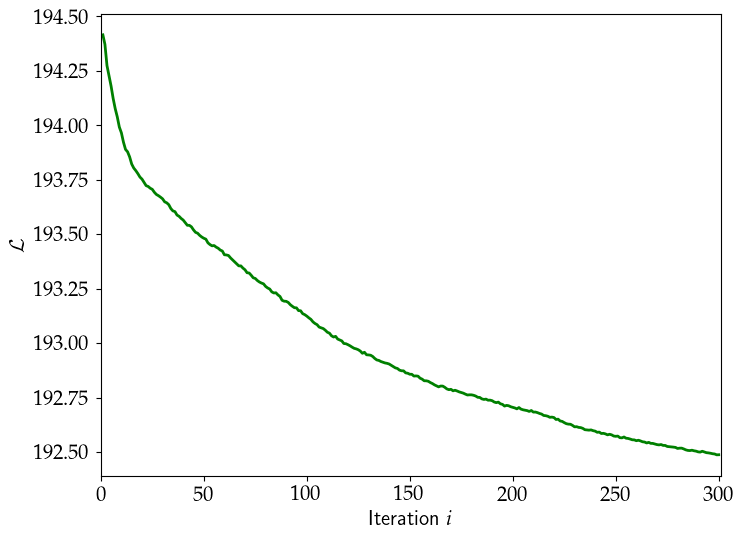

In [72]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(1, len(losses) + 1, 1), losses, lw = 2, c= 'g')
plt.ylabel(r'$\mathcal{L}$', fontsize = fontSize)
plt.xlabel(r'Iteration $i$', fontsize = fontSize)
plt.xlim(0, len(losses)+1)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig('../plots/optimisation.pdf', bbox_inches = 'tight')
plt.show()

In [73]:
losses[-1]

192.48884820211984

In [74]:
# # cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param), bias, deltaz_gc = unpack_params_vec(params) 

# unpack_params_vec(opt_params) 

# Approximate Hessian

In [78]:
params

Array([ 8.52111726e-01,  2.39347515e-01,  5.39530881e-02,  6.52920610e-01,
        9.33002258e-01,  7.37762600e-02,  1.85721610e-01, -7.52631900e-02,
       -1.08286710e-01, -8.46738000e-03, -1.00250930e-01, -1.77734000e-03,
       -9.68797000e-03,  3.58989070e-01, -1.13503300e-02,  1.33889417e+00,
        1.57640662e+00,  1.59644491e+00,  1.90517272e+00,  1.93960129e+00,
        2.24675400e-02, -1.46808000e-03,  2.05147800e-02,  9.68391000e-03,
       -1.23199900e-02], dtype=float64)

In [79]:
opt_params

Array([ 0.88103329,  0.21281283,  0.05236359,  0.73799539,  0.93532489,
        0.31976927,  0.26738758, -0.09742085, -0.1553411 , -0.05447291,
       -0.11567499,  0.04703257,  0.09576642,  0.19225828,  0.08370762,
        1.36325038,  1.56151211,  1.57356962,  1.97095871,  1.97968355,
        0.03098178,  0.00268341,  0.04603968,  0.06590237,  0.06789772],      dtype=float64)

In [76]:
nll_jit(opt_params).block_until_ready()

Array(192.48699915, dtype=float64)

In [77]:
# here I am using the optimised set of parameters to estimate the hessian
grad_theory = theory_jacobian_jit(opt_params).block_until_ready()

approx_hessian = grad_theory.T @ INVCOV @ grad_theory

This is more stable

# log-Posterior Calculation

In [80]:
def calculate_log_prior(parameters: jnp.ndarray):

    # cosmological parameters 
    sigma8 = jax.scipy.stats.uniform.logpdf(parameters[0], 0.60, 0.40)
    omegac = jax.scipy.stats.uniform.logpdf(parameters[1], 0.07, 0.43)
    omegab = jax.scipy.stats.uniform.logpdf(parameters[2], 0.028, 0.027)
    hubble = jax.scipy.stats.uniform.logpdf(parameters[3], 0.64, 0.18)
    ns = jax.scipy.stats.uniform.logpdf(parameters[4], 0.87, 0.20)

    # multiplicative factor (weak lensing)
    m1 = jax.scipy.stats.norm.logpdf(parameters[5], 0.012, 0.023)
    m2 = jax.scipy.stats.norm.logpdf(parameters[6], 0.012, 0.023)
    m3 = jax.scipy.stats.norm.logpdf(parameters[7], 0.012, 0.023)
    m4 = jax.scipy.stats.norm.logpdf(parameters[8], 0.012, 0.023)

    # shifts (weak lensing)
    dz_wl_1 = jax.scipy.stats.norm.logpdf(parameters[9], -0.001, 0.016) # deltaz_wl 
    dz_wl_2 = jax.scipy.stats.norm.logpdf(parameters[10], -0.019, 0.013)
    dz_wl_3 = jax.scipy.stats.norm.logpdf(parameters[11], 0.009, 0.011)
    dz_wl_4 = jax.scipy.stats.norm.logpdf(parameters[12], -0.018, 0.022)

    # intrinsic alignment
    a_ia = jax.scipy.stats.uniform.logpdf(parameters[13], -5, 10)
    eta = jax.scipy.stats.uniform.logpdf(parameters[14], -5, 10)  

    # multiplicative bias (galaxy clustering)
    b1 = jax.scipy.stats.uniform.logpdf(parameters[15], 0.8, 2.2)
    b2 = jax.scipy.stats.uniform.logpdf(parameters[16], 0.8, 2.2)
    b3 = jax.scipy.stats.uniform.logpdf(parameters[17], 0.8, 2.2)
    b4 = jax.scipy.stats.uniform.logpdf(parameters[18], 0.8, 2.2)
    b5 = jax.scipy.stats.uniform.logpdf(parameters[19], 0.8, 2.2)

    # shifts (galaxy clustering)
    dz_gc_1 = jax.scipy.stats.norm.logpdf(parameters[20], 0.0, 0.007)
    dz_gc_2 = jax.scipy.stats.norm.logpdf(parameters[21], 0.0, 0.007)
    dz_gc_3 = jax.scipy.stats.norm.logpdf(parameters[22], 0.0, 0.006)
    dz_gc_4 = jax.scipy.stats.norm.logpdf(parameters[23], 0.0, 0.01)
    dz_gc_5 = jax.scipy.stats.norm.logpdf(parameters[24], 0.0, 0.01)
    
    cosmology = sigma8 + omegac + omegab + hubble + ns 
    multiplicative = m1 + m2 + m3 + m4 
    shifts_wl = dz_wl_1 + dz_wl_2 + dz_wl_3 + dz_wl_4
    intrinsic = a_ia + eta 
    bias = b1 + b2 + b3 + b4 + b5
    shifts_gc = dz_gc_1 + dz_gc_2 + dz_gc_3 + dz_gc_4 + dz_gc_5
    
    logprior = cosmology + multiplicative + shifts_wl + intrinsic + bias + shifts_gc 
    return -logprior

# Sampling with EMCEE

In [81]:
def emcee_lnpost(parameters):
    if np.any(np.isinf(parameters)) or np.any(np.isnan(parameters)):
        return -1E32
    else:
        n_logprior = calculate_log_prior(parameters)
        n_loglike = nll_jit(parameters).block_until_ready()
        logpost = -(n_logprior + n_loglike)
        if np.isfinite(logpost):
            return logpost
    return -1E32

In [82]:
import emcee
from jax import random
key = random.PRNGKey(0)

In [83]:
initial = jnp.array([0.8, 0.25, 0.04, 0.70, 1.0, 
                    0.0, 0.0, 0.0, 0.0,
                    0.0, 0.0, 0.0, 0.0,
                    0.0, 0.0,
                    1.35, 1.55, 1.55, 1.95, 1.95, 
                    0.0, 0.0, 0.0, 0.0, 0.0])

In [84]:
emcee_lnpost(initial)

Array(-216.82444088, dtype=float64)

In [104]:
eps = 1.0 # jnp.diag(jnp.linalg.inv(approx_hessian))
factor = 1E-4 # we need this for stable sampling

In [105]:
nparams = len(opt_params)
pos = initial + factor * eps * random.normal(key, (2*nparams, nparams))
nwalkers, ndim = pos.shape

In [106]:
nsamples = 5000
iter_number = 2

In [107]:
# sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee_lnpost)
# sampler.run_mcmc(pos, nsamples, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [7:58:20<00:00,  5.74s/it]


In [108]:
sampler.flatlnprobability

array([-216.90731341, -216.87581262, -216.80458249, ..., -168.7765403 ,
       -166.99895416, -168.8018173 ])

In [109]:
if jcp.USE_EMU:
    sampler_fname = f'samples_emu_{nwalkers}_{nsamples}_{iter_number}'
else:
    sampler_fname = f'samples_jaxcosmo_{nwalkers}_{nsamples}_{iter_number}'

In [110]:
import os 
import pickle 

def pickle_save(file: list, folder: str, fname: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder, exist_ok=True)

    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        pickle.dump(file, dummy)

In [111]:
# pickle_save(sampler, 'samples', sampler_fname)

# Numpyro

In [74]:
import os
import pandas as pd
import numpyro
from numpyro.infer import init_to_feasible
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value, init_to_median
from numpyro.handlers import seed, trace, condition
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

In [75]:
newcov = jnp.diag(DATACOV) * jnp.eye(NDATA) # DATACOV + np.eye(DATACOV.shape[0])*1E-18
invnewcov = jnp.linalg.inv(newcov)

(jnp.linalg.eigvals(newcov).real >= 0.0).all()


yerr = jnp.sqrt(jnp.diag(DATACOV))
chol_factor = jnp.linalg.cholesky(newcov)
inv_chol_factor = jnp.linalg.inv(chol_factor)
logdet = 2.0 * jnp.sum(jnp.diag(chol_factor))

In [76]:
def mvn_logpdf(sample, mean, inv_chol, logdet):
    chi = inv_chol @ (sample - mean)
    chi2 = chi @ chi 
    return -0.5 * logdet - 0.5 * chi2

In [77]:
def Uniform(name, min_value, max_value):
    """Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    scale = (max_value - min_value) / 6.0
    return numpyro.sample(
        name,
        dist.TransformedDistribution(
            dist.Uniform(-3.0, 3.0),
            AffineTransform(min_value + 3.0 * scale, scale),
        ),
    )

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

In [78]:
def generate_ref_params(parameters: jnp.ndarray):
    
    parameters = [parameters[i].item() for i in range(len(parameters))]
    
    ref_params = {
        "sigma8": parameters[0],
        "Omegac": parameters[1],
        "Omegab": parameters[2],
        "hubble": parameters[3],
        "ns": parameters[4],
        "m1": parameters[5],
        "m2": parameters[6],
        "m3": parameters[7],
        "m4": parameters[8],
        "dz_wl_1": parameters[9],
        "dz_wl_2": parameters[10],
        "dz_wl_3": parameters[11],
        "dz_wl_4": parameters[12],
        "a_ia": parameters[13],
        "eta": parameters[14],
        "b1": parameters[15],
        "b2": parameters[16],
        "b3": parameters[17],
        "b4": parameters[18],
        "b5": parameters[19],
        "dz_gc_1": parameters[20],
        "dz_gc_2": parameters[21],
        "dz_gc_3": parameters[22],
        "dz_gc_4": parameters[23],
        "dz_gc_5": parameters[24]
    }
    return ref_params

In [79]:
def model_sampling(): #(covariance, data = None):

    #  Cosmological params
    sigma8 = Uniform("sigma8", 0.6, 1.0)
    Omegac = Uniform("Omegac", 0.07, 0.50)
    Omegab = Uniform("Omegab", 0.03, 0.07)
    hubble = Uniform("hubble", 0.64, 0.82)
    ns = Uniform("ns", 0.87, 1.07)

    # multiplicative factor (weak lensing)
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    m4 = numpyro.sample("m4", dist.Normal(0.012, 0.023))

    # shifts (weak lensing)
    dz_wl_1 = numpyro.sample("dz_wl_1", dist.Normal(-0.001, 0.016)) # deltaz_wl 
    dz_wl_2 = numpyro.sample("dz_wl_2", dist.Normal(-0.019, 0.013))
    dz_wl_3 = numpyro.sample("dz_wl_3", dist.Normal(0.009, 0.011))
    dz_wl_4 = numpyro.sample("dz_wl_4", dist.Normal(-0.018, 0.022))

    # intrinsic alignment
    a_ia = Uniform("a_ia", -5, 5)
    eta = Uniform("eta", -5, 5)
    
    # multiplicative bias (galaxy clustering)
    b1 = Uniform("b1", 0.8, 3.0)
    b2 = Uniform("b2", 0.8, 3.0)
    b3 = Uniform("b3", 0.8, 3.0)
    b4 = Uniform("b4", 0.8, 3.0)
    b5 = Uniform("b5", 0.8, 3.0)

    # shifts (galaxy clustering)
    dz_gc_1 = numpyro.sample("dz_gc_1", dist.Normal(0.0, 0.007))
    dz_gc_2 = numpyro.sample("dz_gc_2", dist.Normal(0.0, 0.007))
    dz_gc_3 = numpyro.sample("dz_gc_3", dist.Normal(0.0, 0.006))
    dz_gc_4 = numpyro.sample("dz_gc_4", dist.Normal(0.0, 0.01))
    dz_gc_5 = numpyro.sample("dz_gc_5", dist.Normal(0.0, 0.01))
       
    # build the parameter vector 
    parameter_vector = jnp.array([sigma8, Omegac, Omegab, hubble, ns, 
                                  m1, m2, m3, m4,
                                 dz_wl_1, dz_wl_2, dz_wl_3, dz_wl_4,
                                 a_ia, eta,
                                 b1, b2, b3, b4, b5,
                                 dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5])

    # calculate the theory vector 
    # theory = theory_calculation(parameter_vector).flatten()
    theory = theory_jit(parameter_vector)

    sampling_distribution = dist.MultivariateNormal(theory, covariance_matrix=newcov)
    theory_sample = numpyro.sample('theory', sampling_distribution)
    return theory_sample, parameter_vector

In [133]:
def model_sampling_second(data, covariance):
    
    #  Cosmological params
    sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
    Omegac = numpyro.sample("Omegac", dist.Uniform(0.14, 0.35))
    Omegab = numpyro.sample("Omegab", dist.Uniform(0.03, 0.055))
    hubble = numpyro.sample("hubble", dist.Uniform(0.64, 0.82))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))

    # multiplicative factor (weak lensing)
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    m4 = numpyro.sample("m4", dist.Normal(0.012, 0.023))

    # shifts (weak lensing)
    dz_wl_1 = numpyro.sample("dz_wl_1", dist.Normal(-0.001, 0.016)) # deltaz_wl 
    dz_wl_2 = numpyro.sample("dz_wl_2", dist.Normal(-0.019, 0.013))
    dz_wl_3 = numpyro.sample("dz_wl_3", dist.Normal(0.009, 0.011))
    dz_wl_4 = numpyro.sample("dz_wl_4", dist.Normal(-0.018, 0.022))

    # intrinsic alignment
    a_ia = numpyro.sample("a_ia", dist.Uniform(-1, 1))
    eta = numpyro.sample("eta", dist.Uniform(-5.0, 5.0))
    
    # multiplicative bias (galaxy clustering)
    b1 = numpyro.sample("b1", dist.Uniform(0.8, 3.0))
    b2 = numpyro.sample("b2", dist.Uniform(0.8, 3.0))
    b3 = numpyro.sample("b3", dist.Uniform(0.8, 3.0))
    b4 = numpyro.sample("b4", dist.Uniform(0.8, 3.0))
    b5 = numpyro.sample("b5", dist.Uniform(0.8, 3.0))

    # shifts (galaxy clustering)
    dz_gc_1 = numpyro.sample("dz_gc_1", dist.Normal(0.0, 0.007))
    dz_gc_2 = numpyro.sample("dz_gc_2", dist.Normal(0.0, 0.007))
    dz_gc_3 = numpyro.sample("dz_gc_3", dist.Normal(0.0, 0.006))
    dz_gc_4 = numpyro.sample("dz_gc_4", dist.Normal(0.0, 0.01))
    dz_gc_5 = numpyro.sample("dz_gc_5", dist.Normal(0.0, 0.01))
       
    # build the parameter vector 
    parameter_vector = jnp.array([sigma8, Omegac, Omegab, hubble, ns, 
                                  m1, m2, m3, m4,
                                 dz_wl_1, dz_wl_2, dz_wl_3, dz_wl_4,
                                 a_ia, eta,
                                 b1, b2, b3, b4, b5,
                                 dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5])

    # calculate the theory vector 
    # theory = theory_calculation(parameter_vector).flatten()
    theory = theory_jit(parameter_vector).flatten()

    # some of the theory values are NaNs
    isnan = jnp.isnan(theory)
    theory = jnp.where(isnan, 0.0, theory)
    # data = jnp.where(isnan, 0.0, data)
    # covariance = jnp.where(isnan, 0.0, covariance)
    # covariance = jnp.where(isnan[:,None], 0.0, covariance)

    sampling_distribution = dist.MultivariateNormal(theory, covariance_matrix=covariance)
    theory_sample = numpyro.sample('y', sampling_distribution, obs = data)
    log_prob = sampling_distribution.log_prob(theory_sample)

    return theory_sample, parameter_vector, log_prob

In [134]:
param_dict = generate_ref_params(params) 

In [135]:
fiducial_model = condition(model_sampling_second, param_dict)

In [136]:
with seed(rng_seed=42):
    test, param_sample, log_prob = fiducial_model(data=DATA, covariance = newcov)

In [137]:
# numpyro.render_model(model_sampling_second, model_args=(DATA, DATACOV))
# observed_model = condition(model_sampling, {'theory': DATA})
# observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)

In [138]:
sample_logp = []
sample_params = []
for i in range(1000):
    rng = np.random.randint(1E10)
    with seed(rng_seed=rng):
        test, param_sample, log_prob = model_sampling_second(data=DATA, covariance = newcov)
    sample_logp.append(log_prob)
    sample_params.append(param_sample)

In [139]:
sample_logp = jnp.asarray(sample_logp)
sample_params = jnp.asarray(sample_params)

In [140]:
generate_ref_params(sample_params[sample_logp > 6500][3])

{'sigma8': 0.7134118016138418,
 'Omegac': 0.15786177696465004,
 'Omegab': 0.049435563842653095,
 'hubble': 0.7089173402530861,
 'ns': 0.9290588144643944,
 'm1': 0.017098856317791632,
 'm2': 0.012372828250056629,
 'm3': 0.036884891711843545,
 'm4': -0.014690128347248445,
 'dz_wl_1': -0.004311959204771432,
 'dz_wl_2': -0.018934930723515847,
 'dz_wl_3': -0.003425525626807634,
 'dz_wl_4': -0.006454055706503259,
 'a_ia': 0.21654957545620812,
 'eta': -4.126065570798736,
 'b1': 1.4385330390328164,
 'b2': 2.050576273079621,
 'b3': 1.7027241594726763,
 'b4': 2.089308850325534,
 'b5': 2.719857085939326,
 'dz_gc_1': -0.008824998718600386,
 'dz_gc_2': -0.00604453876316159,
 'dz_gc_3': 0.003319318948589331,
 'dz_gc_4': -0.004571634858986294,
 'dz_gc_5': -0.003066378188420274}

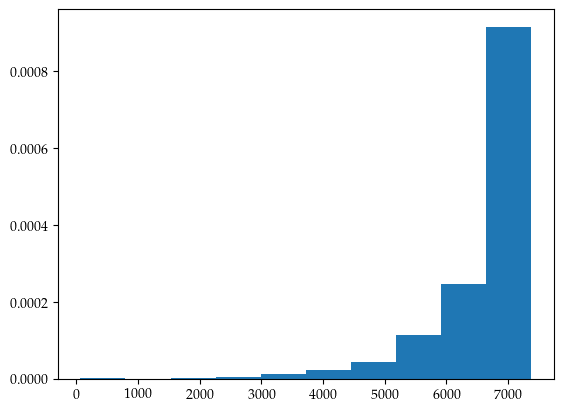

In [141]:
plt.hist(sample_logp[sample_logp > 0.0], density = True)
plt.show()

In [142]:
bad_params = sample_params[sample_logp < 0.0]

In [143]:
sample_logp[sample_logp < 0.0]

Array([], dtype=float64)

In [144]:
bad_params.shape[0]

0

In [145]:
pd.DataFrame([generate_ref_params(bad_params[idx_bad]) for idx_bad in range(bad_params.shape[0])]).iloc[:, 0:10]

""


In [146]:
pd.DataFrame([generate_ref_params(bad_params[idx_bad]) for idx_bad in range(bad_params.shape[0])]).iloc[:, 10:]

""


In [502]:
idx_bad = 0
test_bp_gc, test_bp_gc_wl, test_bp_wl = theory_jit_individual(bad_params[idx_bad])
theory_test = theory_jit(bad_params[idx_bad])

In [148]:
# observed_model_reparam = numpyro.handlers.reparam(model_sampling, config=config)

In [77]:
# with seed(rng_seed=250):
#     observed_model_reparam(newcov, DATA)
# jnp.linalg.eigvals(DATACOV)[jnp.linalg.eigvals(DATACOV).real < 0]
# eigvals_newcov = jnp.linalg.eigvals(newcov).real
# eigvals_datacov = jnp.linalg.eigvals(DATACOV).real
# (eigvals_newcov > 0).all()
# (eigvals_datacov > 0).all()
# jnp.linalg.det(DATACOV)
# jnp.linalg.cholesky(DATACOV)
# dist.MultivariateNormal(DATA, covariance_matrix=DATACOV).sample(random.PRNGKey(15))[0:10]

In [518]:
# dist.MultivariateNormal(theory_test, covariance_matrix=newcov).sample(random.PRNGKey(10), sample_shape=(1000,))

In [79]:
# nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
#                                  step_size=1e-1, 
#                                  init_strategy=numpyro.infer.init_to_median,
#                                  dense_mass=True,
#                                  max_tree_depth=5)

# mcmc = numpyro.infer.MCMC(nuts_kernel, 
#                           num_warmup=200, 
#                           num_samples=500,
#                           num_chains=32,
#                           chain_method='vectorized',
#                           progress_bar=False)

# Without Parallelisation

In [147]:
rng_seed = 400
NWARMUP = 20
NSAMPLES = 50
REF_PARAMS = generate_ref_params(params) # opt_params

In [148]:
numpyro.set_host_device_count(1)
# jax.device_count()

In [149]:
# nuts_kernel = NUTS(observed_model_reparam,
#                    step_size=0.1, 
#                    init_strategy=init_to_median, # init_to_value(values=REF_PARAMS), 
#                    dense_mass=True, 
#                    max_tree_depth=5)

nuts_kernel = NUTS(model_sampling_second,
                   step_size=0.1, 
                   init_strategy=init_to_value(values=REF_PARAMS), # init_to_feasible(), # init_to_median, # , 
                   dense_mass=True, 
                   max_tree_depth=5)

mcmc = MCMC(nuts_kernel, 
            num_warmup=NWARMUP, 
            num_samples=NSAMPLES,    
            num_chains=1,
            # chain_method="parallel",
            progress_bar=True) #False if "NUMPYRO_SPHINXBUILD" in os.environ else True)

In [150]:
%%time
mcmc.run(jax.random.PRNGKey(rng_seed), DATA, newcov)

2023-08-16 13:22:19.287773: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_theory_calculation] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-08-16 13:23:40.368548: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m21.08089921s

********************************
[Compiling module jit_theory_calculation] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-08-16 13:31:19.601898: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m33.391402366s

********************************
[Compiling module jit_theory_calculation] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*****************************

RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
# samples = mcmc.get_samples()

# Parallelisation

In [104]:
NCHAIN = 8

In [105]:
def do_mcmc(rng_key):
    # nuts_kernel = NUTS(observed_model_reparam, step_size=0.01, init_strategy=init_to_value(values=REF_PARAMS), dense_mass=True, max_tree_depth=5)
    nuts_kernel = NUTS(observed_model_reparam, step_size=0.01, init_strategy=numpyro.infer.init_to_median, dense_mass=True, max_tree_depth=5)
    mcmc = MCMC(nuts_kernel, progress_bar=False, num_chains=NCHAIN, chain_method='vectorized', num_warmup=NWARMUP, num_samples=NSAMPLES)
    mcmc.run(rng_key, DATACOV, PRECISION, extra_fields=("potential_energy",),)
    return {**mcmc.get_samples(), **mcmc.get_extra_fields()}

In [106]:
n_parallel = jax.local_device_count()
rng_keys = jax.random.split(jax.random.PRNGKey(rng_seed), n_parallel)

In [107]:
%%time
traces = jax.pmap(do_mcmc)(rng_keys)

Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator
Not using the emulator


2023-07-06 15:41:34.871623: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 36m48.611578073s

********************************
[Compiling module pmap_do_mcmc] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


CPU times: user 1h 23min 49s, sys: 6min 20s, total: 1h 30min 10s
Wall time: 1h 6min 12s


In [108]:
trace = {k: np.concatenate(v) for k, v in traces.items()}

In [101]:
trace.keys()

dict_keys(['a_ia', 'b1', 'b2', 'b3', 'b4', 'b5', 'diverging', 'dz_gc_1', 'dz_gc_1_decentered', 'dz_gc_2', 'dz_gc_2_decentered', 'dz_gc_3', 'dz_gc_3_decentered', 'dz_gc_4', 'dz_gc_4_decentered', 'dz_gc_5', 'dz_gc_5_decentered', 'dz_wl_1', 'dz_wl_1_decentered', 'dz_wl_2', 'dz_wl_2_decentered', 'dz_wl_3', 'dz_wl_3_decentered', 'dz_wl_4', 'dz_wl_4_decentered', 'eta', 'hubble', 'm1', 'm1_decentered', 'm2', 'm2_decentered', 'm3', 'm3_decentered', 'm4', 'm4_decentered', 'ns', 'omegab', 'omegac', 'potential_energy', 'sigma8'])

# Likelihood Test
This is the minimum generated by Cobaya. 

In [70]:
import pandas as pd
import scipy.stats as ss 
import numpy as np 
import matplotlib.pylab as plt 

In [71]:
with open('minimum2.txt', 'r') as the_file:
    all_data = [line.strip() for line in the_file.readlines()]

In [72]:
columns = list(map(str, all_data[0].split()))
values = list(map(float, all_data[1].split()))

In [73]:
df_cobaya = pd.DataFrame(values, index=columns)

In [74]:
df_cobaya

,0
weight,1.000000
minuslogpost,192.481550
Omega_c,0.217284
Omega_b,0.038872
h,0.711447
n_s,1.001982
sigma8,0.857570
bias_DESgc__0_b1,1.381945
bias_DESgc__1_b1,1.678678
bias_DESgc__2_b1,1.637502


In [75]:
cobaya_cosmo =  jc.Cosmology(sigma8=0.857570, Omega_c=0.217284, Omega_b=0.038872, h=0.711447, n_s=1.001982, 
                      w0=-1., Omega_k=0., wa=0.)

cobaya_params = get_params_vec(cobaya_cosmo, 
                            [0.026009, 0.010605, 0.009821, 0.001751], # multiplicative
                            [0.002806, -0.029086, 0.001544, -0.012942], # shifts wl 
                            [0.339852, 0.995183], # intrinsic alignment
                            [1.381945, 1.678678, 1.637502, 2.006953, 2.074230], # bias parameters
                            [0.002439, 0.005276, 0.001724, 0.001650, 0.002131]) # shifts gc

In [76]:
2*nll_jit(cobaya_params, data, invcov).block_until_ready()

Array(401.94260726, dtype=float64)

Plot prior for $\sigma_{8}$.

In [14]:
# mean_sigma8 = 0.8
# sigma_sigma8 = 0.1
# min_sigma8 = mean_sigma8 - 5 * sigma_sigma8
# max_sigma8 = mean_sigma8 + 5 * sigma_sigma8
# dist = ss.norm(mean_sigma8, sigma_sigma8)
# sigma8_grid = np.linspace(min_sigma8, max_sigma8, 1000)
# sigma8_pdf = dist.pdf(sigma8_grid)

In [9]:
# plt.figure(figsize=(6,4))
# plt.plot(sigma8_grid, sigma8_pdf, lw = 2)
# plt.ylim(0.0, 1.2*max(sigma8_pdf))
# plt.xlim(min_sigma8, max_sigma8)
# plt.show()

# Generate a Triangle Plot

In [152]:
from getdist import plots, MCSamples

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [153]:
# hess_est = grad_nll.reshape(-1, 1) @ grad_nll.reshape(1, -1)
# hess_est_onp = np.array(hess_est)

hess_est_onp = np.array(approx_hessian)

In [154]:
samples = np.random.multivariate_normal(np.array(opt_params), np.linalg.inv(hess_est_onp), 50000)

In [169]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    if fname is not None:
        plt.savefig(f'../plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    plt.close()

In [170]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}$', r'$\delta z_{2}$', r'$\delta z_{3}$', r'$\delta z_{4}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$']

In [171]:
triangle_plot(samples, labels, fname = 'hessian')

Removed no burn in


In [172]:
labels_cosmo = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$']
labels_multi = [r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$']
labels_delta = [r'$\delta z_{1}$', r'$\delta z_{2}$', r'$\delta z_{3}$', r'$\delta z_{4}$']
labels_nuisance = [r'$A_{IA}$', r'$\eta$']
labels_bias = [r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$']

In [173]:
samples_cosmo = samples[:,0:5]
samples_multi = samples[:,5:9]
samples_delta = samples[:,9:13]
samples_nuisance = samples[:,13:15]
samples_bias = samples[:,15:20]

In [174]:
# triangle_plot(samples_cosmo, labels_cosmo, fname = 'hessian_cosmo')
# triangle_plot(samples_multi, labels_multi, fname = 'hessian_multi')
# triangle_plot(samples_delta, labels_delta, fname = 'hessian_delta')
# triangle_plot(samples_nuisance, labels_nuisance, fname = 'hessian_nuisance')
# triangle_plot(samples_bias, labels_bias, fname = 'hessian_bias')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [ ]:
# Blackjax

# import blackjax

# def loglikelihood_sampler(params):
#     return -negative_loglikelihood_param(params)

# nll_sampler_jit = jit(loglikelihood_sampler)

# # Pathfinder
# %%time
# rng_key = jax.random.PRNGKey(314)
# _, info = blackjax.vi.pathfinder.approximate(rng_key, nll_sampler_jit, opt_params, ftol=1e-4)
# path = info.path
# steps = (jnp.isfinite(path.elbo)).sum()

# for i in range(steps):
#     state = jax.tree_map(lambda x: x[i], path)
#     sample_state, _ = blackjax.vi.pathfinder.sample(rng_key, state, 10_000)
#     mu_i, cov_i = sample_state.mean(0), jnp.cov(sample_state, rowvar=False)
#     print(mu_i)
#     print(cov_i)
#     print('-'*50)

# # NUTS
# # Build the kernel
# step_size = 1e-3
# nsamples = 10
# inverse_mass_matrix = jnp.eye(opt_params.shape[0]) # jnp.linalg.inv(approx_hessian)
# # nuts = blackjax.nuts(nll_sampler_jit, step_size, inverse_mass_matrix)
# nuts = blackjax.nuts(loglikelihood_sampler, step_size, inverse_mass_matrix)

# # Initialize the state
# state = nuts.init(opt_params)

# # Iterate
# rng_key = jax.random.PRNGKey(0)
# step = jax.jit(nuts.step)
# record = []
# for i in range(nsamples):
#     rng_key, nuts_key = jax.random.split(rng_key)
#     state, _ = step(nuts_key, state)
#     position = state.position
#     print(position)
# #     record.append({k: position[k].item() for k in position.keys()})